In [1]:
!pip install supervision
!pip install roboflow
!pip install pybboxes
!pip install super-gradients
!git clone https://github.com/Jozefov/mAP.git
!git clone https://github.com/immersive-limit/coco-manager.git

fatal: destination path 'mAP' already exists and is not an empty directory.
fatal: destination path 'coco-manager' already exists and is not an empty directory.


In [35]:
import json
import os
from PIL import Image
import pybboxes as pbx
import yaml
import shutil
import random
from collections import Counter
import cv2

In [3]:
!mkdir -p /data/coco/

# Download the annotation ZIP and extract it, then remove the ZIP file
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip -d /data/coco/
!rm annotations_trainval2017.zip

# Download the train2017 ZIP, extract it, and remove the ZIP file
# !wget http://images.cocodataset.org/zips/train2017.zip
# !unzip -q train2017.zip -d /data/coco/
# !rm train2017.zip

# Download the val2017 ZIP, extract it, and remove the ZIP file
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip -d /data/coco/
!rm val2017.zip

--2024-08-15 12:25:25--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.122.33, 54.231.131.225, 3.5.24.171, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.122.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  39.5MB/s    in 6.7s    

2024-08-15 12:25:32 (35.9 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

--2024-08-15 12:25:46--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.177, 16.182.105.217, 3.5.28.169, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zi

In [4]:
!python /content/coco-manager/filter.py --input_json /data/coco/annotations/instances_val2017.json --output_json /data/coco/annotations/filtered_val.json --categories person dog cat

Loading json file...
Processing input json...
Filtering...
Saving new json file...
Filtered json saved.


In [5]:
with open('/data/coco/annotations/filtered_val.json', 'r') as f:
    data = json.load(f)

categories = data['categories']
category_id_to_name = {category['id']: category['name'] for category in categories}

for category_id, category_name in category_id_to_name.items():
    print(f"ID: {category_id}, Name: {category_name}")


# Print a few sample annotations
# for i, annotation in enumerate(data['annotations']):
#     print(f"Annotation {i+1}:")
#     print(json.dumps(annotation, indent=4))
#     print()
#     if i == 1:
#         break


ID: 1, Name: person
ID: 2, Name: cat
ID: 3, Name: dog


In [6]:
with open('/data/coco/annotations/instances_val2017.json', 'r') as f:
    data = json.load(f)

categories = data['categories']
category_id_to_name = {category['id']: category['name'] for category in categories}

for category_id, category_name in category_id_to_name.items():
    print(f"ID: {category_id}, Name: {category_name}")


ID: 1, Name: person
ID: 2, Name: bicycle
ID: 3, Name: car
ID: 4, Name: motorcycle
ID: 5, Name: airplane
ID: 6, Name: bus
ID: 7, Name: train
ID: 8, Name: truck
ID: 9, Name: boat
ID: 10, Name: traffic light
ID: 11, Name: fire hydrant
ID: 13, Name: stop sign
ID: 14, Name: parking meter
ID: 15, Name: bench
ID: 16, Name: bird
ID: 17, Name: cat
ID: 18, Name: dog
ID: 19, Name: horse
ID: 20, Name: sheep
ID: 21, Name: cow
ID: 22, Name: elephant
ID: 23, Name: bear
ID: 24, Name: zebra
ID: 25, Name: giraffe
ID: 27, Name: backpack
ID: 28, Name: umbrella
ID: 31, Name: handbag
ID: 32, Name: tie
ID: 33, Name: suitcase
ID: 34, Name: frisbee
ID: 35, Name: skis
ID: 36, Name: snowboard
ID: 37, Name: sports ball
ID: 38, Name: kite
ID: 39, Name: baseball bat
ID: 40, Name: baseball glove
ID: 41, Name: skateboard
ID: 42, Name: surfboard
ID: 43, Name: tennis racket
ID: 44, Name: bottle
ID: 46, Name: wine glass
ID: 47, Name: cup
ID: 48, Name: fork
ID: 49, Name: knife
ID: 50, Name: spoon
ID: 51, Name: bowl
ID: 5

In [7]:

with open('/data/coco/annotations/filtered_val.json', 'r') as f:
    filtered_data = json.load(f)

filtered_image_ids = {annotation['image_id'] for annotation in filtered_data['annotations']}

filtered_images = [image for image in filtered_data['images'] if image['id'] in filtered_image_ids]

filtered_dataset = {
    'images': filtered_images,
    'annotations': filtered_data['annotations'],
    'categories': filtered_data['categories']
}



In [8]:
def remove_unlisted_images(image_dir, filtered_dataset):
    """
    Removes all images from the specified directory that are not listed in the filtered dataset (after class filtration).

    Parameters:
    - image_dir (str): The directory containing the images to be filtered.
    - filtered_dataset (dict): Dictionary containing filtered 'images', 'annotations', and 'categories'.

    Description:
    This function scans the provided image directory and removes any image files that are not
    present in the `filtered_dataset['images']` list.
    """

    retained_images = {image_info['file_name'] for image_info in filtered_dataset['images']}

    all_images = set(os.listdir(image_dir))

    unlisted_images = all_images - retained_images

    for image_filename in unlisted_images:
        image_path = os.path.join(image_dir, image_filename)
        os.remove(image_path)

    print(f"Cleanup complete. {len(unlisted_images)} unlisted images have been removed.")



In [9]:
# Remove unlisted images
remove_unlisted_images("/data/coco/val2017", filtered_dataset)

Cleanup complete. 2055 unlisted images have been removed.


In [10]:
filtered_dataset['categories']

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'animal', 'id': 2, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 3, 'name': 'dog'}]

In [11]:
len(filtered_dataset['images'])

2945

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="API_key")
project = rf.workspace("atathamuscoinsdataset").project("u.s.-coins-dataset-a.tatham")
dataset = project.version(5).download("yolov5")

In [13]:
def coco_to_yolo(coco_annotation_path, images_dir, output_dir, yaml_output_path=None):
    """
    Converts COCO format annotations to YOLO format and generates a YAML file describing the dataset.

    Parameters:
    - coco_annotation_path (str): Path to the COCO annotation JSON file.
    - images_dir (str): Directory containing the images referenced in the COCO annotations.
    - output_dir (str): Directory where YOLO format annotation files will be saved.
    - yaml_output_path (str, optional): Path to save the generated YAML file. If None, it will save in the `output_dir`.

    Description:
    This function reads annotations from a COCO format JSON file and converts them to the YOLO format.
    It also generates a `data.yaml` file that describes the dataset.
    In YOLO format, each image has a corresponding .txt file containing the bounding box annotations.
    Each line in the .txt file follows the format:

    class_id center_x center_y width height

    Where:
    - `class_id` is the ID of the object class (starting from 0).
    - `center_x`, `center_y` are the normalized coordinates of the bounding box center.
    - `width`, `height` are the normalized dimensions of the bounding box.

    The coordinates and dimensions are normalized with respect to the image width and height.

    The function processes each annotation in the COCO dataset, converts the bounding box to YOLO format
    using the `pybboxes` library, and saves the results in a .txt file named after the corresponding image.

    """


    with open(coco_annotation_path, 'r') as f:
        coco_data = json.load(f)

    class_names = [category['name'] for category in coco_data['categories']]

    os.makedirs(output_dir, exist_ok=True)

    category_id_to_yolo_id = {category['id']: idx for idx, category in enumerate(coco_data['categories'])}

    # Process each annotation
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        bbox = annotation['bbox']

        # Get image file name and size
        image_info = next(image for image in coco_data['images'] if image['id'] == image_id)
        image_filename = image_info['file_name']
        image_path = os.path.join(images_dir, image_filename)

        if not os.path.exists(image_path):
            print(f"Warning: Label file not found for image: {image_path}")
            continue

        with Image.open(image_path) as img:
            image_size = img.size  # (width, height)

        yolo_bbox = pbx.convert_bbox(bbox, from_type="coco", to_type="yolo", image_size=image_size)

        yolo_class_id = category_id_to_yolo_id[category_id]

        yolo_annotation_line = f"{yolo_class_id} {' '.join(map(str, yolo_bbox))}\n"

        yolo_annotation_file = os.path.join(output_dir, f"{os.path.splitext(image_filename)[0]}.txt")

        with open(yolo_annotation_file, 'a') as yolo_file:
            yolo_file.write(yolo_annotation_line)

    yaml_content = {
        'nc': len(class_names),                     # Number of classes
        'names': class_names                        # List of class names
    }

    # Determine where to save the YAML file
    if yaml_output_path is None:
        yaml_output_path = os.path.join(output_dir, 'data.yaml')

    # Save the YAML file
    with open(yaml_output_path, 'w') as yaml_file:
        yaml.dump(yaml_content, yaml_file)

    print(f"YOLO annotations and data.yaml have been saved to {output_dir}")

In [18]:
# clean folders
!rm -r /data/coco/annotations/yolo_format/

In [19]:
coco_to_yolo(
    coco_annotation_path='/data/coco/annotations/filtered_val.json',
    images_dir='/data/coco/val2017',
    output_dir='/data/coco/annotations/yolo_format/',
    yaml_output_path= '/data/coco/data.yaml',
)

YOLO annotations and data.yaml have been saved to /data/coco/annotations/yolo_format/


In [20]:
def create_dataset(filtered_dataset, dataset_params, input_params, split_ratios=(0.7, 0.2, 0.1), move_files=False):
    """
    Create a dataset structure for training, validation, and test sets with images and YOLO labels.

    Parameters:
    - filtered_dataset (dict): Dictionary containing filtered 'images', 'annotations', and 'categories'.
    - dataset_params (dict): Dictionary defining the dataset structure and paths.
    - input_params (dict): Dictionary defining the input structure with paths to images, labels and datast yaml file.
    - split_ratios (tuple): Ratios for splitting the dataset into (train, valid, test).
    - move_files (bool): Whether to move files instead of copying.

    Description:
    This function divides images into train, validation, and test sets based on the provided split ratios.
    Labels has to be first processed by coco_to_yolo function. It then copies or moves the images
    and corresponding YOLOv5 format label files from the input directories to the designated
    output folders as per the structure defined in `dataset_params`.
    """

    for dir_path in [dataset_params['train_images_dir'], dataset_params['train_labels_dir'],
                     dataset_params['val_images_dir'], dataset_params['val_labels_dir'],
                     dataset_params['test_images_dir'], dataset_params['test_labels_dir']]:
        full_path = os.path.join(dataset_params['data_dir'], dir_path)
        os.makedirs(full_path, exist_ok=True)

    images = filtered_dataset['images']
    random.shuffle(images)

    train_idx = int(len(images) * split_ratios[0])
    val_idx = train_idx + int(len(images) * split_ratios[1])

    train_images = images[:train_idx]
    val_images = images[train_idx:val_idx]
    test_images = images[val_idx:]

    def process_images(image_set, image_dir, label_dir):
        for image_info in image_set:
            image_filename = image_info['file_name']
            yolo_label_filename = os.path.splitext(image_filename)[0] + '.txt'

            image_src_path = os.path.join(input_params['images_dir'], image_filename)
            label_src_path = os.path.join(input_params['labels_dir'], yolo_label_filename)

            image_dest_path = os.path.join(dataset_params['data_dir'], image_dir, image_filename)
            label_dest_path = os.path.join(dataset_params['data_dir'], label_dir, yolo_label_filename)

            # Copy or move files
            if move_files:
                shutil.move(image_src_path, image_dest_path)
                shutil.move(label_src_path, label_dest_path)
            else:
                shutil.copy(image_src_path, image_dest_path)
                shutil.copy(label_src_path, label_dest_path)

    # Process each set
    process_images(train_images, dataset_params['train_images_dir'], dataset_params['train_labels_dir'])
    process_images(val_images, dataset_params['val_images_dir'], dataset_params['val_labels_dir'])
    process_images(test_images, dataset_params['test_images_dir'], dataset_params['test_labels_dir'])

    if move_files:
        shutil.move(input_params['dataset_yaml'], dataset_params['data_dir'])
    else:
        shutil.copy(input_params['dataset_yaml'], dataset_params['data_dir'])

    print(f"Dataset created in {dataset_params['data_dir']} with train/val/test splits.")

In [21]:
dataset_params = {
    'data_dir': '/content/dataset_train',
    'train_images_dir': 'train/images',
    'train_labels_dir': 'train/labels',
    'val_images_dir': 'valid/images',
    'val_labels_dir': 'valid/labels',
    'test_images_dir': 'test/images',
    'test_labels_dir': 'test/labels',
    'classes': ['person', 'cat', 'dog']
}

input_params = {
    'images_dir': '/data/coco/val2017',
    'labels_dir': '/data/coco/annotations/yolo_format',
    'dataset_yaml': '/data/coco/data.yaml'
}

split_ratios = (0.7, 0.2, 0.1)

create_dataset(filtered_dataset, dataset_params, input_params, split_ratios=split_ratios, move_files=False)

Dataset created in /content/dataset_train with train/val/test splits.


## Test

In [22]:
def test_dataset_creation(input_params, dataset_params, split_ratios):
    """
    Test if the dataset creation was successful by checking if all images and annotations
    from the input directories are present in the output directories and are split
    according to the specified proportions.
    """
    # List all files in the input directories
    input_images = set(os.listdir(input_params['images_dir']))
    input_labels = set(os.listdir(input_params['labels_dir']))

    # List all files in the output directories
    train_images = set(os.listdir(os.path.join(dataset_params['data_dir'], dataset_params['train_images_dir'])))
    train_labels = set(os.listdir(os.path.join(dataset_params['data_dir'], dataset_params['train_labels_dir'])))

    val_images = set(os.listdir(os.path.join(dataset_params['data_dir'], dataset_params['val_images_dir'])))
    val_labels = set(os.listdir(os.path.join(dataset_params['data_dir'], dataset_params['val_labels_dir'])))

    test_images = set(os.listdir(os.path.join(dataset_params['data_dir'], dataset_params['test_images_dir'])))
    test_labels = set(os.listdir(os.path.join(dataset_params['data_dir'], dataset_params['test_labels_dir'])))

    # Check if all images and labels were moved or copied
    output_images = train_images | val_images | test_images
    output_labels = train_labels | val_labels | test_labels

    assert input_images == output_images, f"Mismatch in images. Missing images: {input_images - output_images}"
    assert input_labels == output_labels, f"Mismatch in labels. Missing labels: {input_labels - output_labels}"

    # Check proportions
    total_images = len(input_images)
    total_labels = len(input_labels)

    assert len(train_images) == len(train_labels), "Mismatch between training images and labels"
    assert len(val_images) == len(val_labels), "Mismatch between validation images and labels"
    assert len(test_images) == len(test_labels), "Mismatch between test images and labels"

    expected_train_size = int(total_images * split_ratios[0])
    expected_val_size = int(total_images * split_ratios[1])
    expected_test_size = total_images - expected_train_size - expected_val_size

    assert len(train_images) == expected_train_size, f"Training set size is incorrect. Expected {expected_train_size}, got {len(train_images)}"
    assert len(val_images) == expected_val_size, f"Validation set size is incorrect. Expected {expected_val_size}, got {len(val_images)}"
    assert len(test_images) == expected_test_size, f"Test set size is incorrect. Expected {expected_test_size}, got {len(test_images)}"

    print("All tests passed successfully.")

In [23]:
test_dataset_creation(input_params, dataset_params, split_ratios)

All tests passed successfully.


# Train model on custom dataset


In [24]:
import torch
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

[2024-08-15 12:28:32] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-08-15 12:28:43] INFO - utils.py - NumExpr defaulting to 2 threads.


In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [27]:


train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)



[2024-08-15 12:28:47] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 2061/2061 [00:00<00:00, 5059.26it/s]
[2024-08-15 12:28:47] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 589/589 [00:00<00:00, 4675.64it/s]
[2024-08-15 12:28:48] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:   0%|          | 0/295 [00:00<?, ?it/s]

In [28]:
train_data.dataset.transforms

Indexing dataset annotations: 100%|██████████| 295/295 [00:00<00:00, 4044.70it/s]


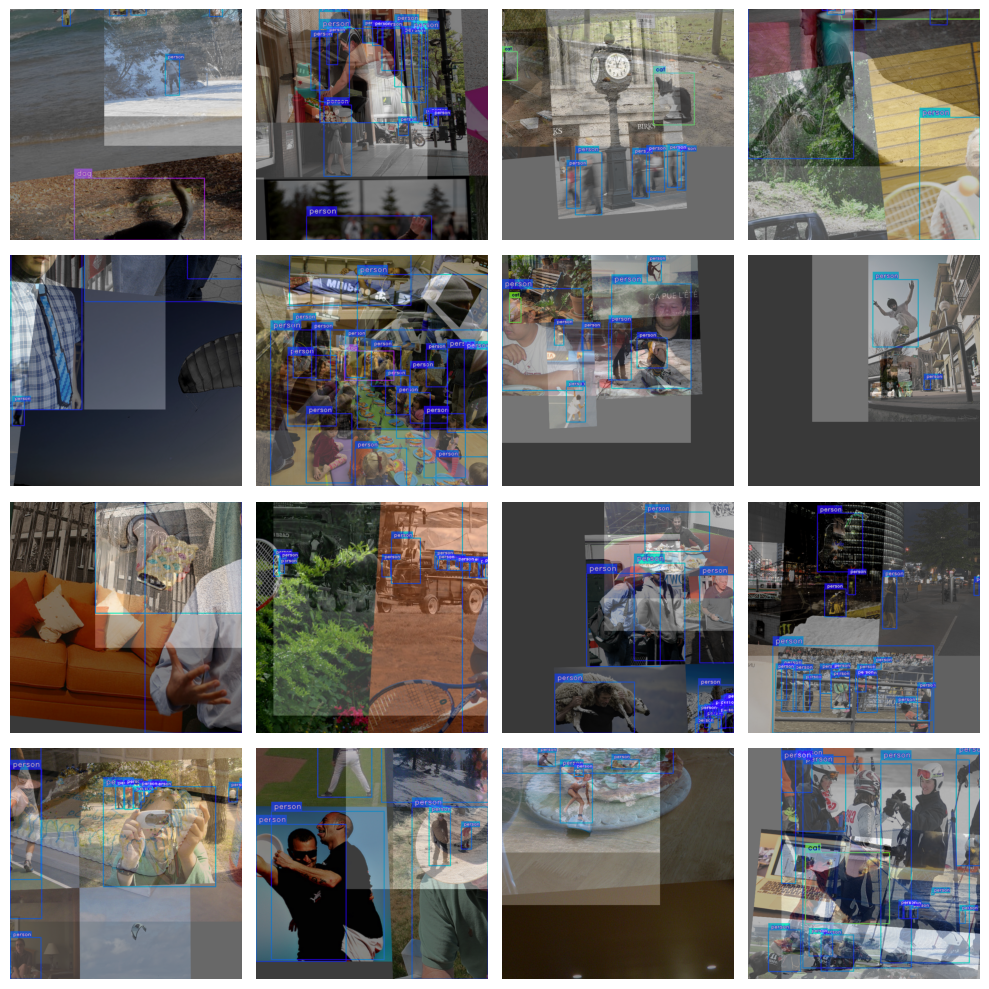

In [29]:
train_data.dataset.plot()

In [57]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

In [58]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 3,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}


A reg_max argument is not needed for PPYoloE loss anymore. It is deprecated since SG 3.6.0 and will be removed in the SG 3.8.0.You can safely omit this argument as it is not used anymore and we infer it automatically from model's outputs


In [59]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-08-15 12:53:25] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240815_125325_842203`
[2024-08-15 12:53:25] INFO - sg_trainer.py - Checkpoints directory: checkpoints/my_first_yolonas_run/RUN_20240815_125325_842203
[2024-08-15 12:53:25] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/my_first_yolonas_run/RUN_20240815_125325_842203/console_Aug15_12_53_25.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[2024-08-15 12:53:29] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            2061       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_s

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.9841
│   ├── Ppyoloeloss/loss_iou = 0.7269
│   ├── Ppyoloeloss/loss_dfl = 0.7092
│   └── Ppyoloeloss/loss = 3.4202
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7752
    ├── Ppyoloeloss/loss_iou = 0.5147
    ├── Ppyoloeloss/loss_dfl = 0.5329
    ├── Ppyoloeloss/loss = 2.8228
    ├── Precision@0.50 = 0.1673
    ├── Recall@0.50 = 0.08
    ├── Map@0.50 = 0.0843
    ├── F1@0.50 = 0.1082
    └── Best_score_threshold = 0.0



Validating epoch 1: 100%|██████████| 74/74 [00:18<00:00,  3.95it/s]
[2024-08-15 13:00:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/RUN_20240815_125325_842203/ckpt_best.pth
[2024-08-15 13:00:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3293095529079437


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1504
│   │   ├── Epoch N-1      = 1.9841 (↘ -0.8338)
│   │   └── Best until now = 1.9841 (↘ -0.8338)
│   ├── Ppyoloeloss/loss_iou = 0.629
│   │   ├── Epoch N-1      = 0.7269 (↘ -0.0979)
│   │   └── Best until now = 0.7269 (↘ -0.0979)
│   ├── Ppyoloeloss/loss_dfl = 0.6591
│   │   ├── Epoch N-1      = 0.7092 (↘ -0.0501)
│   │   └── Best until now = 0.7092 (↘ -0.0501)
│   └── Ppyoloeloss/loss = 2.4385
│       ├── Epoch N-1      = 3.4202 (↘ -0.9817)
│       └── Best until now = 3.4202 (↘ -0.9817)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0427
    │   ├── Epoch N-1      = 1.7752 (↘ -0.7325)
    │   └── Best until now = 1.7752 (↘ -0.7325)
    ├── Ppyoloeloss/loss_iou = 0.4984
    │   ├── Epoch N-1      = 0.5147 (↘ -0.0164)
    │   └── Best until now = 0.5147 (↘ -0.0164)
    ├── Ppyoloeloss/loss_dfl = 0.5516
    │   ├── Epoch N-1      = 0.5329 (↗ 0.0187)
    │   └── Best until now = 0.5329 (↗ 0.0187)
    ├── Ppyoloeloss/loss 

Validating epoch 2: 100%|██████████| 74/74 [00:18<00:00,  3.90it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1344
│   │   ├── Epoch N-1      = 1.1504 (↘ -0.0159)
│   │   └── Best until now = 1.1504 (↘ -0.0159)
│   ├── Ppyoloeloss/loss_iou = 0.6366
│   │   ├── Epoch N-1      = 0.629  (↗ 0.0076)
│   │   └── Best until now = 0.629  (↗ 0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.6786
│   │   ├── Epoch N-1      = 0.6591 (↗ 0.0195)
│   │   └── Best until now = 0.6591 (↗ 0.0195)
│   └── Ppyoloeloss/loss = 2.4496
│       ├── Epoch N-1      = 2.4385 (↗ 0.0111)
│       └── Best until now = 2.4385 (↗ 0.0111)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0934
    │   ├── Epoch N-1      = 1.0427 (↗ 0.0507)
    │   └── Best until now = 1.0427 (↗ 0.0507)
    ├── Ppyoloeloss/loss_iou = 0.5341
    │   ├── Epoch N-1      = 0.4984 (↗ 0.0358)
    │   └── Best until now = 0.4984 (↗ 0.0358)
    ├── Ppyoloeloss/loss_dfl = 0.5828
    │   ├── Epoch N-1      = 0.5516 (↗ 0.0313)
    │   └── Best until now = 0.5329 (↗ 0.05)
    ├── Ppyoloeloss/loss = 2.2104
  

[2024-08-15 13:03:29] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 3: 100%|██████████| 74/74 [00:18<00:00,  5.92it/s]

In [60]:
# Use last checkpoint
checkpoints_base_dir = "/content/checkpoints/my_first_yolonas_run"

checkpoint_dirs = [d for d in os.listdir(checkpoints_base_dir) if os.path.isdir(os.path.join(checkpoints_base_dir, d))]
checkpoint_dirs.sort()
latest_checkpoint_dir = checkpoint_dirs[-1]
latest_checkpoint_path = os.path.join(checkpoints_base_dir, latest_checkpoint_dir, 'ckpt_best.pth')
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path=latest_checkpoint_path)

print(f"Using checkpoint from: {latest_checkpoint_path}")

In [61]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

[2024-08-15 13:03:51] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/my_first_yolonas_run/RUN_20240815_125325_842203/ckpt_best.pth EMA checkpoint.
Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Using checkpoint from: /content/checkpoints/my_first_yolonas_run/RUN_20240815_125325_842203/ckpt_best.pth


Testing:  97%|█████████▋| 36/37 [00:11<00:00,  4.13it/s]

{'PPYoloELoss/loss_cls': 1.0338145,
 'PPYoloELoss/loss_iou': 0.5053262,
 'PPYoloELoss/loss_dfl': 0.551161,
 'PPYoloELoss/loss': 2.0903018,
 'Precision@0.50': 0.015677958726882935,
 'Recall@0.50': 0.810444176197052,
 'mAP@0.50': 0.29041311144828796,
 'F1@0.50': 0.03050905279815197,
 'Best_score_threshold': 0.3199999928474426}

# Validate train model

In [62]:
# Path to your COCO validation images
coco_val_directory = '/content/dataset_train/test/images'

# List all jpg images in the validation directory
# Also important as on this will be based your sortings of prediction
image_paths = [os.path.join(coco_val_directory, img) for img in os.listdir(coco_val_directory) if img.endswith('.jpg')]


In [63]:
model_predictions = best_model.to(device).predict(image_paths, conf=0.15)

Testing: 100%|██████████| 37/37 [00:12<00:00,  3.05it/s]
It seems you are using predict() with batch input
Predicting Images:  76%|███████▋  | 225/295 [00:03<00:00, 82.51it/s]

In [64]:
def generate_ground_truth(image_dir,label_dir, output_dir, class_mapping, input_format_truth='yolo', input_format_pred='voc'):
    """
    Converts YOLOv5 annotations and model predictions to the required format for mAP evaluation.

    Args:
        image_dir (str): Directory containing image files (e.g., JPG).
        label_dir (str): Directory containing YOLOv5 TXT label files (class_id center_x center_y width height).
                         The label files should have the same base name as the corresponding image
                         files, with the extension .txt.
        output_dir (str): Directory to save the ground-truth and detection-results files.
                          The ground-truth files will be saved in `output_dir/ground-truth/` and
                          the detection-results files will be saved in `output_dir/detection-results/`.
        class_mapping (dict): A dictionary mapping class IDs (int) to class names (str).
                              For example: {0: 'Dime', 1: 'Nickel', 2: 'Penny', 3: 'Quarter'}.
        input_format_truth (str, optional): The format of the input ground-truth bounding boxes.
                                            Default is 'yolo', assuming YOLOv5 format.
        input_format_pred (str, optional): The format of the input prediction bounding boxes.
                                           Default is 'voc', assuming VOC format.

    Returns:
        None: The function writes the converted ground-truth and detection-results files to the specified
              `output_dir` in a format compatible with the Cartucho/mAP evaluation tool.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    gt_dir = os.path.join(output_dir, 'ground-truth')
    dr_dir = os.path.join(output_dir, 'detection-results')
    os.makedirs(gt_dir, exist_ok=True)
    os.makedirs(dr_dir, exist_ok=True)


    for image_name in os.listdir(image_dir):
        if image_name.endswith('.jpg'):
            # Extract the base name without extension to find the corresponding label file
            base_name = os.path.splitext(image_name)[0]
            label_file = os.path.join(label_dir, f"{base_name}.txt")

            if not os.path.exists(label_file):
                print(f"Warning: Label file not found for image: {image_name}")
                continue

            # Load the image to get its size
            image_path = os.path.join(image_dir, image_name)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Could not load image: {image_name}")
                continue

            image_height, image_width = image.shape[:2]
            image_size = (image_width, image_height)

            output_file = os.path.join(gt_dir, f"{base_name}.txt")

            with open(label_file, 'r') as lf, open(output_file, 'w') as of:
                for line in lf:
                    try:
                        class_id, center_x, center_y, width, height = map(float, line.strip().split())
                    except:
                        continue

                    bbox = [center_x, center_y, width, height]

                    # Convert YOLO format (center_x, center_y, width, height) to (xmin, ymin, xmax, ymax)
                    converted_bbox = pbx.convert_bbox(bbox, from_type=input_format_truth, to_type='coco', image_size=image_size)

                    xmin, ymin, w, h = converted_bbox
                    xmax = xmin + w
                    ymax = ymin + h

                    # Assuming class_id maps directly to category name
                    class_name = class_mapping[int(class_id)]

                    of.write(f"{class_name} {xmin} {ymin} {xmax} {ymax}\n")

    # Process model predictions
    for image_path, predictions in zip(image_paths, model_predictions):
        image_file = os.path.basename(image_path)

        if not os.path.exists(label_file):
            print(f"Warning: Label file not found for image: {image_name}")
            continue

        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image: {image_name}")
            continue

        image_height, image_width = image.shape[:2]
        image_size = (image_width, image_height)

        output_file = os.path.join(dr_dir, image_file.replace('.jpg', '.txt'))

        with open(output_file, 'w') as f:
            for j, score in enumerate(predictions.prediction.confidence):
                category_name = predictions.class_names[predictions.prediction.labels[j]].replace(' ', '_')
                bbox = predictions.prediction.bboxes_xyxy[j]

                converted_back_bbox = pbx.convert_bbox(bbox, from_type=input_format_pred, to_type="coco", image_size=image_size)

                xmin, ymin, width, height = converted_back_bbox
                xmax = xmin + width
                ymax = ymin + height

                f.write(f"{category_name} {score} {xmin} {ymin} {xmax} {ymax}\n")


In [40]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [65]:
# clean folders
!rm -r /content/mAP/input/ground-truth/
!rm -r /content/mAP/input/detection-results/
!rm -r /content/mAP/input/images-optional

Predicting Images: 100%|██████████| 295/295 [00:03<00:00, 80.94it/s]


In [66]:
# Example usage:
image_dir = '/content/dataset_train/test/images'
label_dir = '/content/dataset_train/test/labels'
output_dir = '/content/mAP/input'

class_mapping = {0: 'person', 1: 'cat', 2: 'dog'}

generate_ground_truth(image_dir, label_dir, output_dir, class_mapping)

rm: cannot remove '/content/mAP/input/images-optional': No such file or directory


In [67]:
# Evaluate
%cd /content/
%cd mAP
!python main.py -na
%cd /content/

/content
/content/mAP
24.33% = cat AP 
11.67% = dog AP 
52.84% = person AP 
mAP = 29.61%
Figure(640x480)
